## This code is intended to identify the best correlation by mapping the correlation results between the average rainfall area and the average atmospheric parameter area for each grid.

In [ ]:
#import Library
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import cm, Basemap
from scipy.stats import pearsonr
import cartopy.crs as ccrs
import netCDF4 as nc

In [2]:
#Read Data
#This data obtained from GSMAP and IMERG NASA
df=pd.read_csv('rainfall.csv')

#Resample data daily and sum
df['time'] = pd.to_datetime(df['time'])
df = df.resample('D', on='time').sum()
df

,imerg,gsmap
time,,
2018-01-01,0.548293,0.522931
2018-01-02,11.442953,2.274073
2018-01-03,16.924893,7.639314
2018-01-04,10.931562,3.884845
2018-01-05,4.713392,2.027779
...,...,...
2022-12-27,12.484982,2.754064
2022-12-28,38.176224,30.297875
2022-12-29,37.825348,10.374267


In [3]:
ds=xr.open_dataset('./ncfile/tcwv.nc')
ds

C:\ProgramData\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


<xarray.Dataset>
Dimensions:      (time: 1826, lat: 81, lon: 111)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2022-12-31
    realization  int64 ...
  * lat          (lat) int32 -40 -39 -38 -37 -36 -35 -34 ... 35 36 37 38 39 40
  * lon          (lon) int32 70 71 72 73 74 75 76 ... 175 176 177 178 179 180
Data variables:
    tcwv         (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.7
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      2023-11-08T18:15 GRIB to CDM+CF via cfgrib-0.9.9.1/ecCodes-...
    source:       ECMWF

In [4]:
lon_range = slice(80, 160) # determine Lon & Lat
lat_range = slice(-20, 30)
lon_slice_size = 2 #Size Lon & Lat each Grid
lat_slice_size = 2
lag_time= 0

In [5]:
def plot_correlation_map(correlation_data, lon_range, lat_range, lon_slice_size, lat_slice_size, lag_time):
    """
    Plot a correlation map on a basemap.

    Parameters:
    - correlation_data (2D array): Data to be plotted.
    - lon_range (slice): Longitude range.
    - lat_range (slice): Latitude range.
    - lon_slice_size (float): Longitude slice size.
    - lat_slice_size (float): Latitude slice size.
    - lag_time (int): Lag time.

    Returns:
    - None
    """
    fig,ax = plt.subplots(figsize=(30, 20))

    m = Basemap(projection='cyl', llcrnrlat=lat_range.start, urcrnrlat=lat_range.stop,
                llcrnrlon=lon_range.start, urcrnrlon=lon_range.stop, resolution='l')

    # Add coastlines, countries, and grid lines
    m.drawcoastlines()
    m.drawcountries()
    m.drawparallels(np.arange(lat_range.start, lat_range.stop, lat_slice_size), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(lon_range.start, lon_range.stop, lon_slice_size), labels=[0, 0, 0, 1], fontsize=8)

    # Plot contour map
    contour = m.imshow(correlation_data.T, cmap='coolwarm', interpolation='hanning')
    
    # Plot Text Correlation
    aaa = np.arange(lat_range.start, lat_range.stop, lat_slice_size)
    bbb = np.arange(lon_range.start, lon_range.stop, lon_slice_size)

    # loop function for add plot text
    for i in range(len(aaa)):
        for j in range(len(bbb)):
            lat = aaa[i]+(0.5*lat_slice_size)
            lon = bbb[j]+(0.5*lon_slice_size)
            x,y = m(lon,lat)
            nilai_array = correlation_data.T[i, j]
            ax.text(x, y, f'{nilai_array:.2f}', fontsize=6,weight='bold', ha='center', va='bottom')

    # Add a red dot at the reference coordinates
    koordinat_referensi = (106, 107, -8, -6)
    lon1, lon2, lat1, lat2 = koordinat_referensi
    lon_merah = (lon1 + lon2) / 2
    lat_merah = (lat1 + lat2) / 2
    x_merah, y_merah = m(lon_merah, lat_merah)
    ax.plot(x_merah, y_merah, 'rs', markersize=5)

    # Add colorbar
    cbar = m.colorbar(contour, location='bottom', pad="5%")
    cbar.set_label('Korelasi')

    # Show the map
    plt.title('Korelasi Parameter dan Curah Hujan dengan lag time: ' + str(lag_time))
    plt.show()

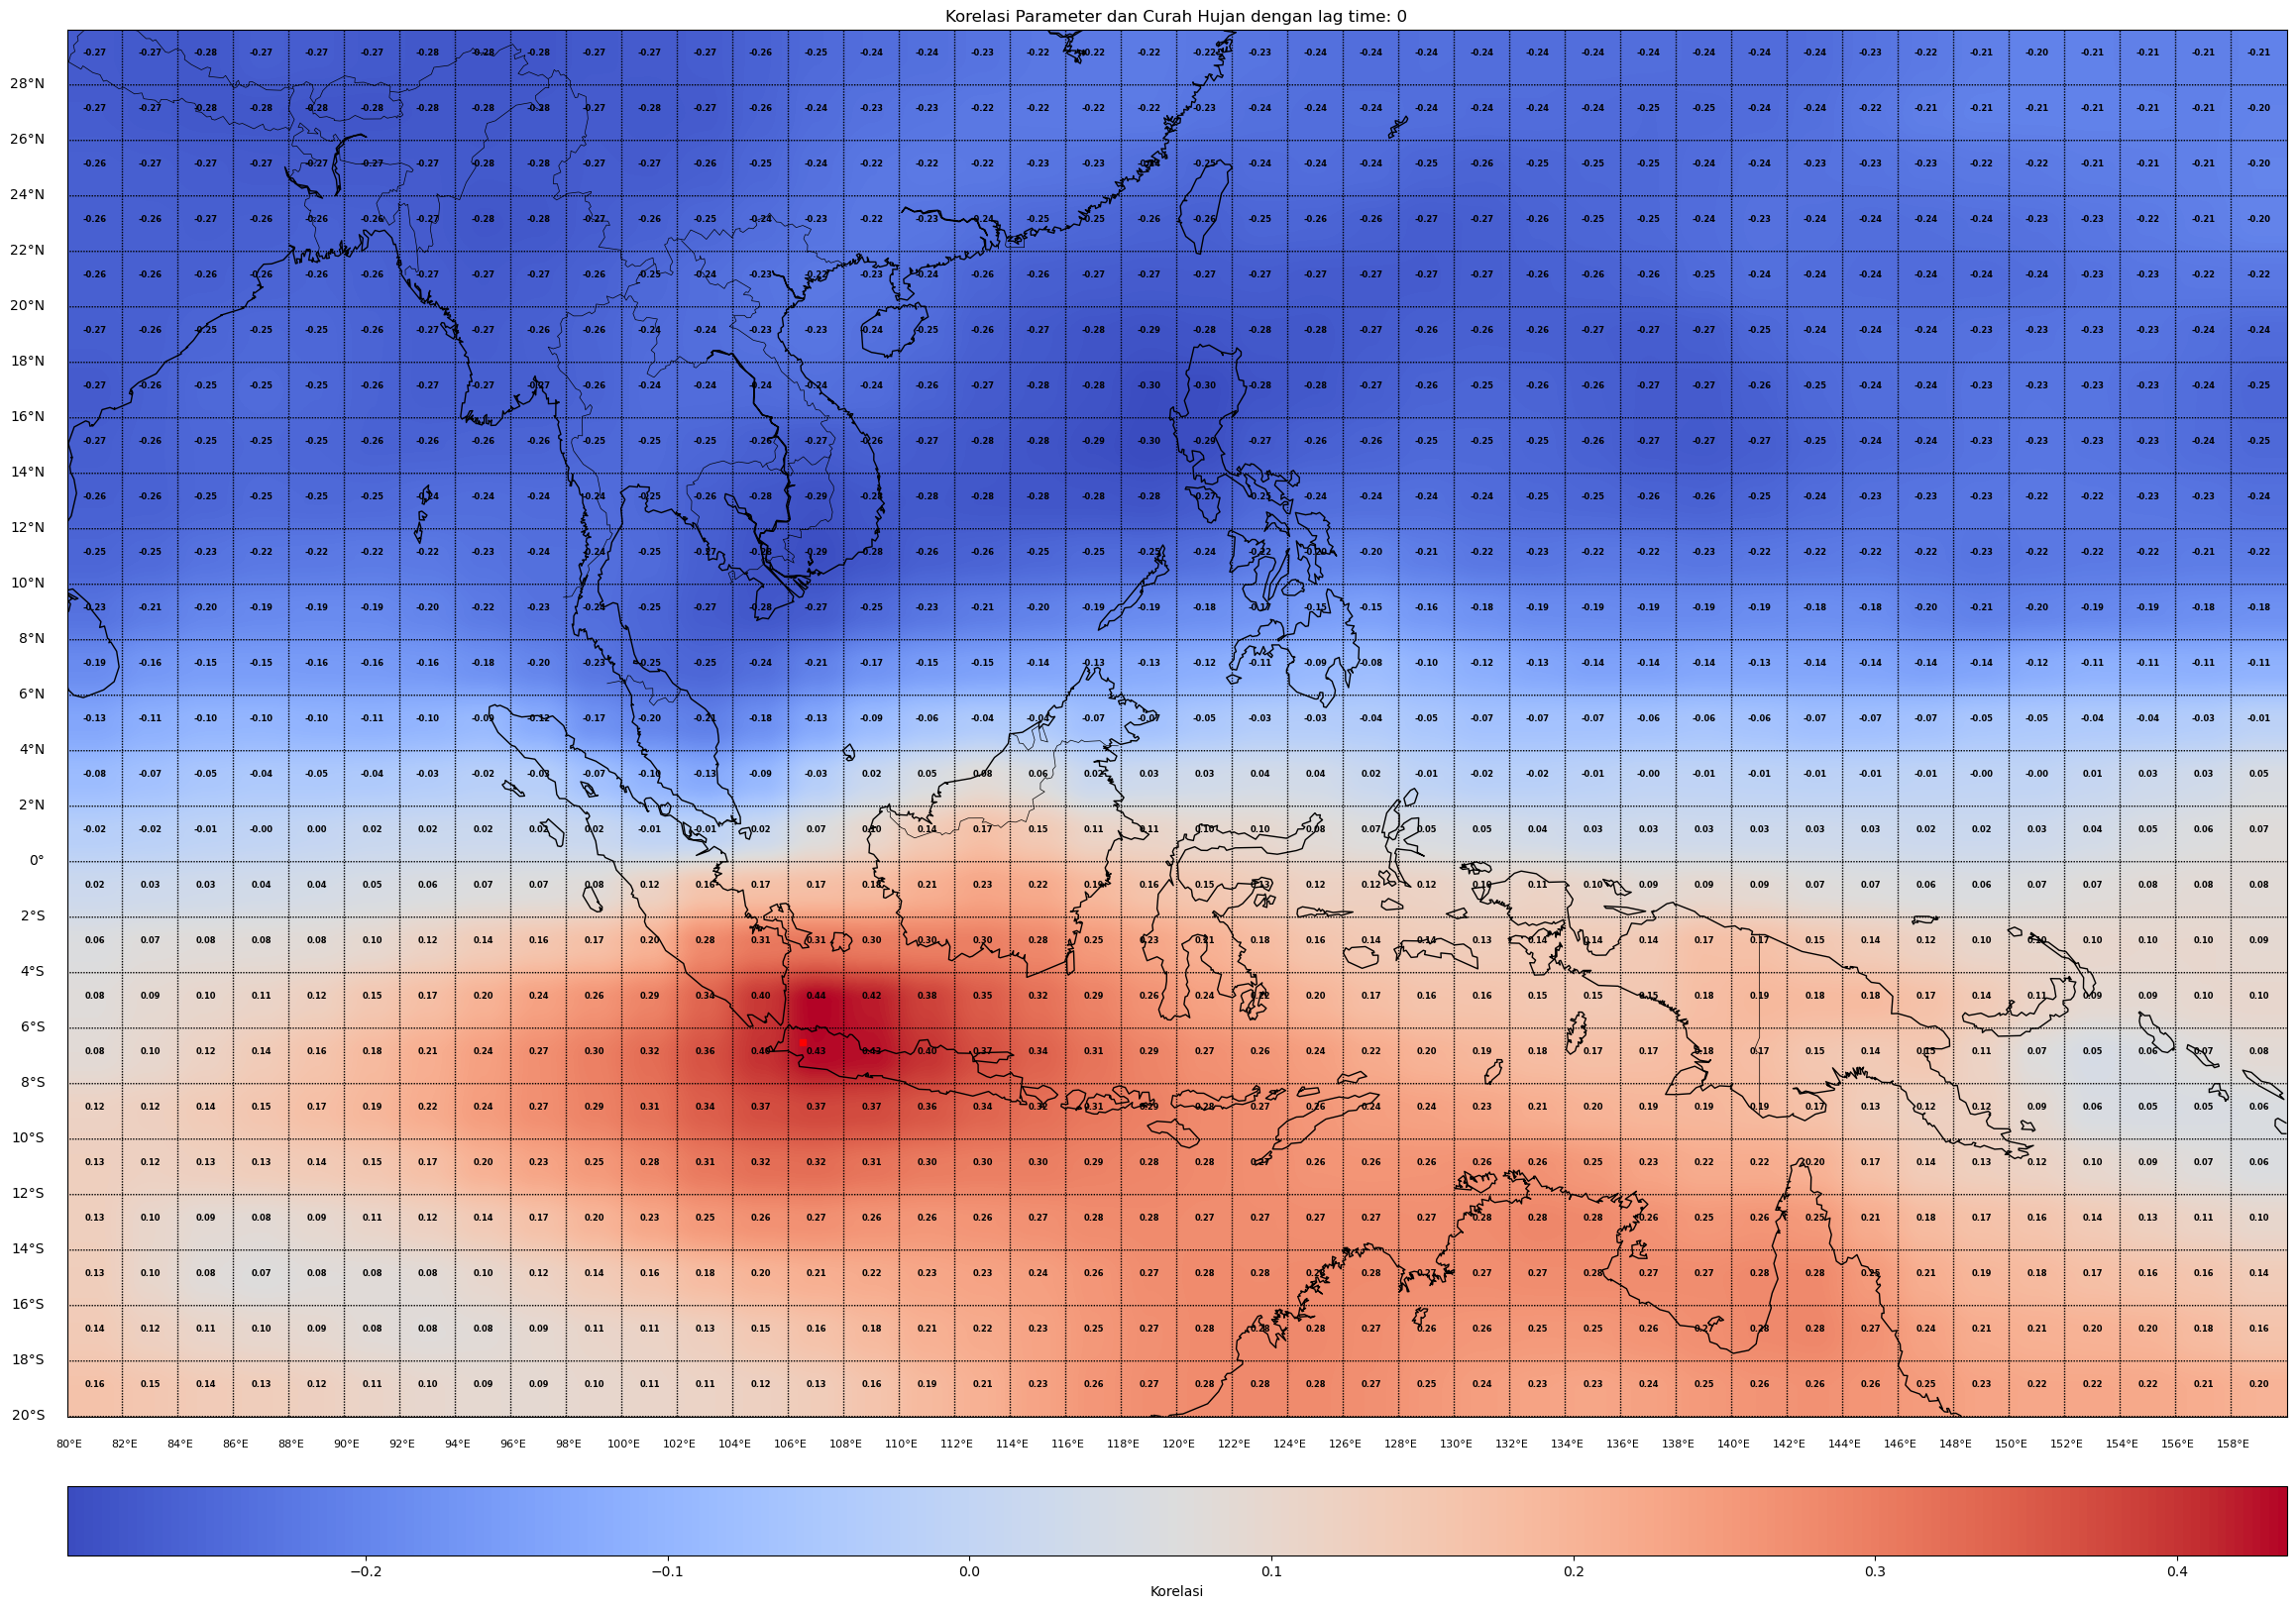

In [7]:
for lag_time in range(1):
    correlation_data = np.empty((len(range(lon_range.start, lon_range.stop, lon_slice_size)),
                                 len(range(lat_range.start, lat_range.stop, lat_slice_size))))

    for lon_index, lon_start in enumerate(range(lon_range.start, lon_range.stop, lon_slice_size)):
        for lat_index, lat_start in enumerate(range(lat_range.start, lat_range.stop, lat_slice_size)):
            lon_slice = slice(lon_start, lon_start + lon_slice_size)
            lat_slice = slice(lat_start, lat_start + lat_slice_size)

            # fetch parameter data in slice
            dataparam = ds['tcwv'].sel(lon=lon_slice, lat=lat_slice)
            # mean data slice
            dataparam = dataparam.fillna(0).mean(("lon", "lat"), skipna=True)

            average_parameter = dataparam[:dataparam.size - lag_time]

            rain = df['imerg'][lag_time:]

            # calculate correlation
            correlation, _ = pearsonr(average_parameter, (rain))

            # save correlation in array with index
            correlation_data[lon_index, lat_index] = correlation

    # Plotting correlation map
    plot_correlation_map(correlation_data, lon_range, lat_range, lon_slice_size, lat_slice_size, lag_time)

#Create dataframe
data = pd.DataFrame()

In [499]:
#Choose best lon and lat slice based on map and save to dataframe
data['tcwv'] =ds['tcwv'].sel(lon=slice(108,110), lat=slice(-7,-6)).fillna(0).mean(("lon", "lat"), skipna=True)
data.to_csv('mergedata.csv',index= False)
data

,precip,v925,v850,v700,v500s,v500u,u925s,u925u,u850s,u850u,...,tcwv,tclw,runoff,lowcloudcover,highcloudcover,mediumcloudcover,totalcloudcover,surfacethermalradiation,vitef,surfacesolarradiation
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.548293,1.384951,2.495328,3.151703,3.183037,5.912082,5.435124,-8.847977,3.946451,-7.979107,...,47.969799,0.045456,0.027940,8.918539,70.445030,13.918687,71.298920,-181250.625000,148.405090,925459.31250
2018-01-02,11.442953,0.771865,2.391636,1.326630,0.373131,11.490075,3.603485,-7.317474,1.957673,-6.411406,...,53.547771,0.040268,0.033158,10.583878,89.867493,18.831064,88.061806,-164698.562500,47.032066,770545.31250
2018-01-03,16.924893,0.515624,0.972307,1.440757,1.140727,12.938642,3.984061,-4.377756,2.814429,-3.916426,...,55.527821,0.049219,0.050140,13.993486,89.574715,31.439304,95.160042,-151791.718750,-200.410156,827160.00000
2018-01-04,10.931562,1.215019,2.410671,2.257869,2.036768,8.047267,4.817695,-2.826999,2.281532,-3.060142,...,56.474869,0.042449,0.068920,11.494287,90.315758,37.256145,95.769211,-137885.031250,-441.910522,739923.37500
2018-01-05,4.713392,1.395525,1.627083,1.886599,-0.325418,7.996705,5.834740,-3.322283,2.414486,-3.329349,...,56.838058,0.112824,0.146866,6.277974,97.772980,74.222824,99.761330,-114395.890625,-1117.094727,602294.62500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,12.484982,-2.986517,-0.694423,0.303334,-0.061691,-6.289434,10.273402,-2.771845,3.111196,-2.897959,...,52.508835,0.120587,0.046132,10.257943,99.870934,48.509377,99.701500,-141226.312500,-307.427246,399696.68750
2022-12-28,38.176224,-3.766452,-1.652398,-1.588259,-8.082353,-12.004309,12.659628,-1.091674,5.559123,-1.188395,...,55.219799,0.082559,0.299007,12.393920,99.931946,66.559692,99.767075,-131367.781250,-977.176025,641266.00000
2022-12-29,37.825348,-6.003848,-3.574223,-1.473010,-7.038042,-11.308855,12.853879,-0.546124,6.429953,-0.776163,...,54.133514,0.088372,0.148520,25.830238,99.887306,53.169189,99.987541,-130930.828125,-1621.946045,456692.65625
